Ce notebook va être consacré au preprocessing du dataset et l'entrainement d'un premier modèle simple pour établir une baseline.

---

# Load

In [301]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

years = range(2019, 2023)

In [302]:
data = pd.DataFrame()

for year in years:
    path = os.path.join(base_path, str(year), file_name)
    year_csv = pd.read_csv(
            path,
            dtype=type_dict,
    )
    year_csv['Year'] = year
    data = pd.concat([
        data,
        year_csv
    ])

# Preprocessing

In [303]:
## TrackStatus ----------------------------------------------------------------

def trackStatus_to_binary(df):
    trackStatus = df['TrackStatus']
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

def process_trackStatus(df):
    trackStatuses = df.apply(trackStatus_to_binary, axis=1)
    return pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1).reset_index(drop=True)

## Missing Data ----------------------------------------------------------------

def process_missing_values(df):
    # TODO fill the missing values better
    df.fillna({
        'DistanceToDriverAhead': 0,
        'GapToLeader': 0,
        'IntervalToPositionAhead': 0,
    }, inplace=True)

    # drop all rows with missing laptime
    df.dropna(subset=['LapTime'], inplace=True)
    return df[df['LapNumber'] > 1]

## Datatypes -------------------------------------------------------------------

def process_datatypes(df):
    # boolean
    df['Green'] = df['Green'].astype('bool')
    df['Yellow'] = df['Yellow'].astype('bool')
    df['SC'] = df['SC'].astype('bool')
    df['Red'] = df['Red'].astype('bool')
    df['VSC'] = df['VSC'].astype('bool')
    df['SC_ending'] = df['SC_ending'].astype('bool')
    df['IsAccurate'] = df['IsAccurate'].astype('bool')
    df['Rainfall'] = df['Rainfall'].astype('bool')
    # category
    df['DriverNumber'] = df['DriverNumber'].astype('category')
    df['Team'] = df['Team'].astype('category')
    df['Compound'] = df['Compound'].astype('category')
    df['DriverAhead'] = df['DriverAhead'].astype('category')
    df['Track'] = df['Track'].astype('category')
    # float
    df['LapStartTime'] = df['LapStartTime'].astype('float32')
    df['LapTime'] = df['LapTime'].astype('float32')
    df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
    df['GapToLeader'] = df['GapToLeader'].astype('float32')
    df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
    df['AirTemp'] = df['AirTemp'].astype('float32')
    df['Humidity'] = df['Humidity'].astype('float32')
    df['Pressure'] = df['Pressure'].astype('float32')
    df['TrackTemp'] = df['TrackTemp'].astype('float32')
    df['WindDirection'] = df['WindDirection'].astype('float32')
    df['WindSpeed'] = df['WindSpeed'].astype('float32')
    # int
    df['LapNumber'] = df['LapNumber'].astype('uint8')
    df['TyreLife'] = df['TyreLife'].astype('uint8')
    df['Stint'] = df['Stint'].astype('uint8')
    df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
    df['Position'] = df['Position'].astype('uint8')
    df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
    df['TotalLaps'] = df['TotalLaps'].astype('uint8')
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

## Remove features -------------------------------------------------------------

def process_remove_features(df):
    df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'PitStatus', 'IsAccurate'], axis=1, inplace=True)
    return df

## Feature encoding ------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder

def process_feature_encoding(df):
    categorical_features = ['Compound', 'Track']
    one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    one_hot_encoder.fit(df[categorical_features])
    one_hot_encoded = one_hot_encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
    print("One hot : ", one_hot_encoded.shape)
    print("Data : ", df.shape)
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df, one_hot_encoder

## Add features ----------------------------------------------------------------

def process_add_features(new_df, df=None):
    #new_df['LapTimeProportional'] = new_df['LapTime'] / df.groupby('Track')['LapTime'].transform('median')
    if df is not None:
        df2 = pd.concat([df, new_df], axis=0)
    else:
        df2 = new_df.copy()
    #df2['cumsum'] = df2.groupby('Track')['LapTime'].cumsum() / df2.groupby('Track')['LapTime'].cumcount().add(1)
    df2['LapTimeProportional'] = df2['LapTime'] / df2.groupby('Track')['LapTime'].expanding().median().reset_index(level=0, drop=True)
    #df2.drop('cumsum', axis=1, inplace=True)
    if df is not None:
        new_df['LapTimeProportional'] = df2.iloc[len(df):, :]['LapTimeProportional']
    else:
        new_df['LapTimeProportional'] = df2['LapTimeProportional']
        df = new_df.copy()

    new_df['RacePercentage'] = new_df['LapNumber'] / new_df['TotalLaps']
    
    average_nb_pit_per_track = df.query('LapNumber == TotalLaps').groupby('Track')['NumberOfPitStops'].mean()
    new_df['DeltaAvgNbPitStop'] =  new_df['NumberOfPitStops'] - new_df['Track'].map(average_nb_pit_per_track).astype('float32')
    
    new_df['LapTimeXLapNumber'] = new_df['LapTime'] * new_df['LapNumber']
    df['LapTimeXLapNumber'] = df['LapTime'] * df['LapNumber']

    laptime_lapnb_corrected_per_track_per_compound = df.groupby(['Track', 'Compound'])['LapTimeXLapNumber'].median()
    new_df = new_df.join(laptime_lapnb_corrected_per_track_per_compound, on=['Track', 'Compound'], rsuffix='_corrected')

    minimum_lap_time_per_stint = df.groupby(['Year', 'Track', 'DriverNumber', 'Stint'])['LapTime'].min()
    #df['MinStint'] = df[['Year', 'Track', 'DriverNumber', 'Stint']].apply(lambda x: minimum_lap_time_per_stint.loc[x['Year'], x['Track'], x['DriverNumber'], x['Stint']], axis=1)
    #df['DMinTimeStint'] = df['LapTime'] - df['MinStint']

    return new_df

In [304]:
def preprocess(df):
    print('Preprocessing data...', df.shape)
    df = process_trackStatus(df)
    print('TrackStatus processed...', df.shape)
    df = process_missing_values(df)
    print('Missing values processed...', df.shape)
    df = process_datatypes(df)
    print('Datatypes processed...', df.shape)
    df = process_target(df)
    print('Target processed...', df.shape)
    df = process_add_features(df)
    print('Features added...', df.shape)
    df = process_remove_features(df)
    print('Features removed...', df.shape)
    df, encoder = process_feature_encoding(df)
    print('Features encoded...', df.shape)
    return df, encoder

In [305]:
df = data.copy()

In [306]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [307]:
from sklearn.model_selection import train_test_split

df, encoder = preprocess(df)

df_training = df.copy()
# remove null values
df.dropna(inplace=True) # TODO find why there are null values

X = df.drop('is_pitting', axis=1)
y = df['is_pitting']


from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(X, y)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preprocessing data... (87845, 28)
TrackStatus processed... (87845, 33)
Missing values processed... (84630, 33)
Datatypes processed... (84630, 33)
Target processed... (84630, 34)


ValueError: cannot join with no overlapping index names

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3864, 63) (966, 63) (3864,) (966,)


# Evaluation  

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    

# Modelisation

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [ ]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))


In [ ]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [ ]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

In [ ]:
#for name, model in dict_of_models.items():
#    print(name)
#    evaluation(model)

In [ ]:
model = RandomForestClassifier(random_state=0,
                               class_weight='balanced_subsample',)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

[[465  40]
 [ 22 439]]
              precision    recall  f1-score   support

       False       0.95      0.92      0.94       505
        True       0.92      0.95      0.93       461

    accuracy                           0.94       966
   macro avg       0.94      0.94      0.94       966
weighted avg       0.94      0.94      0.94       966



# Test

In [ ]:
# Load test data
test_data = pd.read_csv('data/2023/bahrain_grand_prix.csv'
                        , dtype=type_dict)

In [ ]:
test_df_44 = test_data.query('DriverNumber == "44"').copy()
test_df_44.head()

,LapStartTime,LapNumber,LapTime,DriverNumber,Team,Compound,TyreLife,TrackStatus,Stint,DistanceToDriverAhead,DriverAhead,PitStatus,IsAccurate,NumberOfPitStops,Position,GapToLeader,IntervalToPositionAhead,LapsToLeader,Track,TotalLaps,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
16,3756.652100,1,NaN,44,Mercedes,SOFT,4,2,1,NaN,NaN,OutLap,False,0,5,3.269,0.629,0,Sakhir,57,27.299999,22.0,1016.700012,False,31.299999,0.0,0.6
24,3859.210938,2,99.166000,44,Mercedes,SOFT,5,2,1,50.203609,55,NoPit,True,0,5,4.480,0.864,0,Sakhir,57,27.299999,22.0,1016.700012,False,31.200001,190.0,0.6
44,3958.376953,3,99.220001,44,Mercedes,SOFT,6,1,1,62.451946,55,NoPit,True,0,5,5.675,1.040,0,Sakhir,57,27.299999,22.0,1016.900024,False,31.100000,197.0,0.6
64,4057.596924,4,99.197998,44,Mercedes,SOFT,7,1,1,81.827499,55,NoPit,True,0,5,6.897,1.253,0,Sakhir,57,27.299999,22.0,1016.700012,False,31.200001,170.0,0.6
84,4156.794922,5,99.334999,44,Mercedes,SOFT,8,1,1,100.092499,55,NoPit,True,0,5,8.197,1.460,0,Sakhir,57,27.200001,22.0,1016.900024,False,31.100000,236.0,0.8


In [ ]:
def process_feature_encoding_new(df, encoder):
    categorical_features = ['Compound', 'Track']
    one_hot_encoded = encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df

def preprocess_new_data(new_df, df, encoder):
    print('Preprocessing data...', new_df.shape)
    new_df = process_trackStatus(new_df)
    print('TrackStatus processed...', new_df.shape)
    new_df = process_missing_values(new_df)
    print('Missing values processed...', new_df.shape)
    new_df = process_datatypes(new_df)
    print('Datatypes processed...', new_df.shape)
    new_df = process_target(new_df)
    print('Target processed...', df.shape)
    new_df = process_add_features(new_df, df)
    print('Features added...', df.shape)
    new_df = process_remove_features(new_df)
    print('Features removed...', df.shape)
    new_df = process_feature_encoding_new(new_df, encoder)
    print('Features encoded...', new_df.shape)
    return new_df

In [ ]:
test_df_44['Year'] = 2023

test_df_44 = preprocess_new_data(test_df_44, data, encoder)

test_df_44.dropna(inplace=True)

test_df_44.head()

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)


C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_24808\2972325863.py:121: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df2['LapTimeProportional'] = df2['LapTime'] / df2.groupby('Track')['LapTime'].expanding().median().reset_index(level=0, drop=True)


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
x_test_44 = test_df_44.drop('is_pitting', axis=1)
y_test_44 = test_df_44['is_pitting']

print(x_test_44.shape, y_test_44.shape)

(55, 63) (55,)


In [ ]:
ypred_44 = model.predict(x_test_44)

print(confusion_matrix(y_test_44, ypred_44))
print(classification_report(y_test_44, ypred_44))

[[28 25]
 [ 0  2]]
              precision    recall  f1-score   support

       False       1.00      0.53      0.69        53
        True       0.07      1.00      0.14         2

    accuracy                           0.55        55
   macro avg       0.54      0.76      0.41        55
weighted avg       0.97      0.55      0.67        55



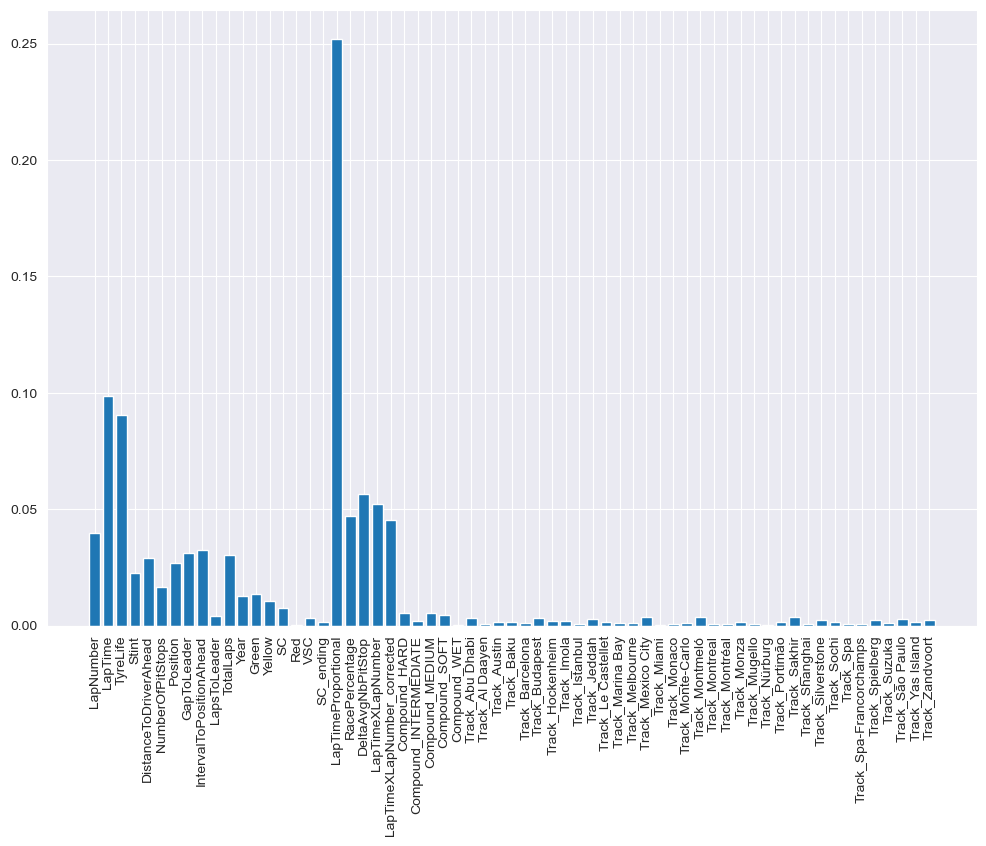

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(x_test_44.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [ ]:
import matplotlib.patches as mpatches
def plot_predictions_by_lapNumber(x_test, y_test, ypred, title=None):
    sns.set_style('darkgrid')
    plt.figure(figsize=(12, 2.5))
    sns.scatterplot(x=x_test['LapNumber'], y=0, hue=y_test, palette='Set1', marker='o')
    sns.scatterplot(x=x_test['LapNumber'], y=0.5, hue=ypred, palette='Set1', marker='o')
    plt.yticks([0, 0.5], ['Actual', 'Predicted'])
    plt.xlabel('Lap Number')
    plt.xticks(np.arange(0, x_test['TotalLaps'].max(), 5))
    plt.ylim(-0.5, 1)
    patch = mpatches.Patch(color='cornflowerblue', label='Pit stop')
    patch2 = mpatches.Patch(color='crimson', label='No pit stop')
    plt.legend(handles=[patch, patch2])
    if title:
        plt.title(title)
    plt.show()

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (56, 64)


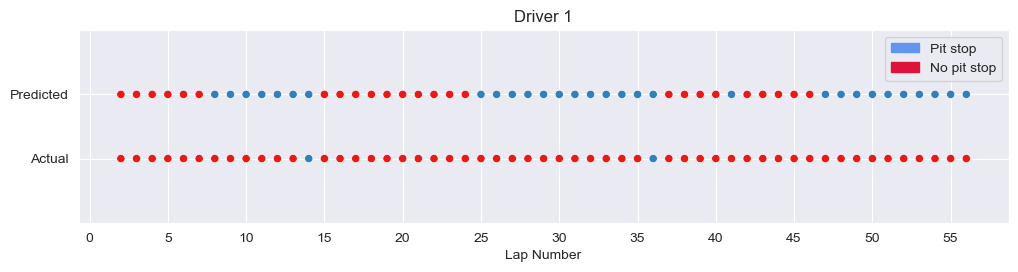

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (56, 64)


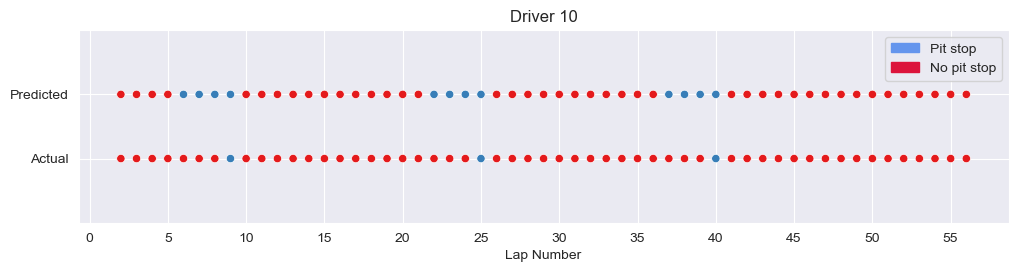

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (56, 64)


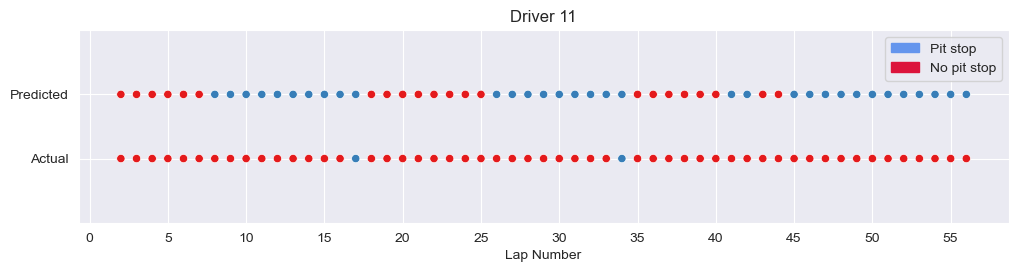

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (55, 33)
Datatypes processed... (55, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (55, 64)


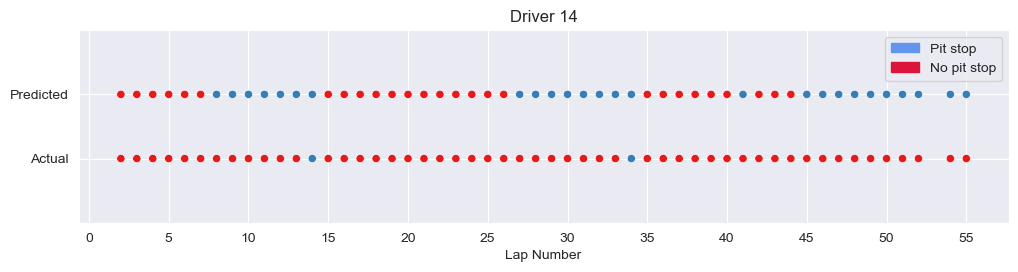

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (56, 64)


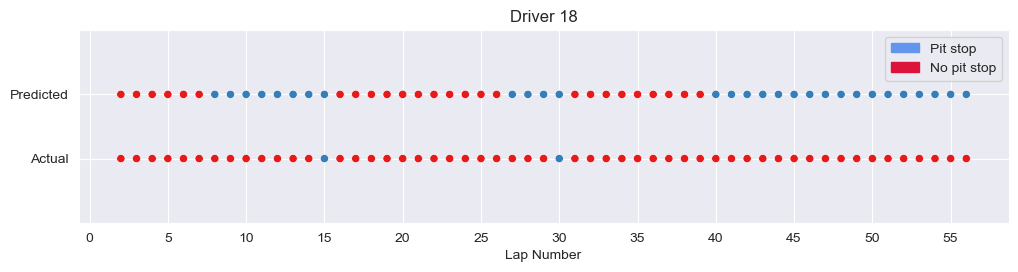

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (56, 64)


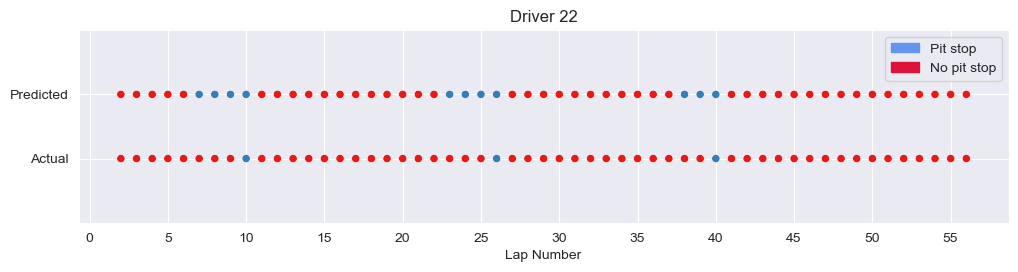

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (56, 64)


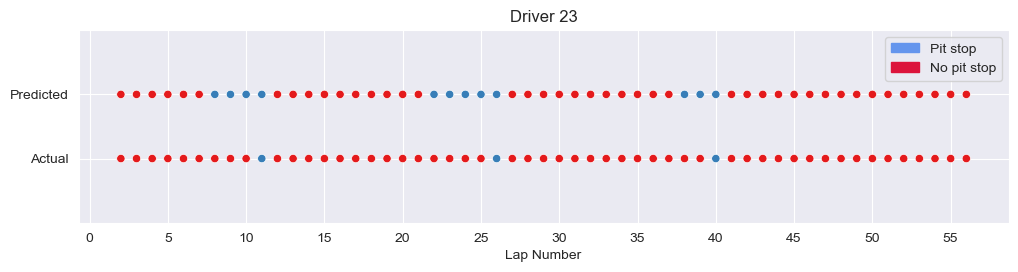

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (56, 64)


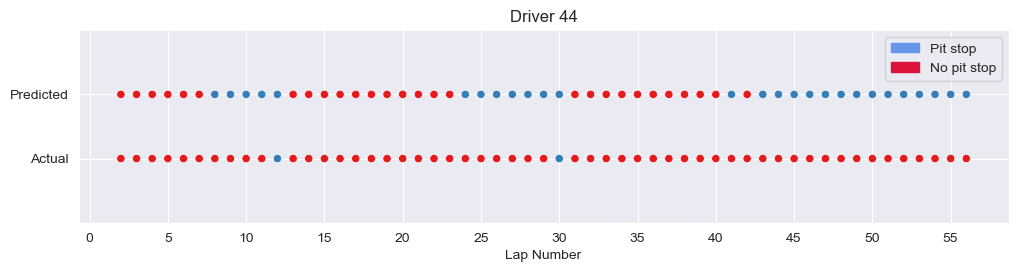

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (56, 64)


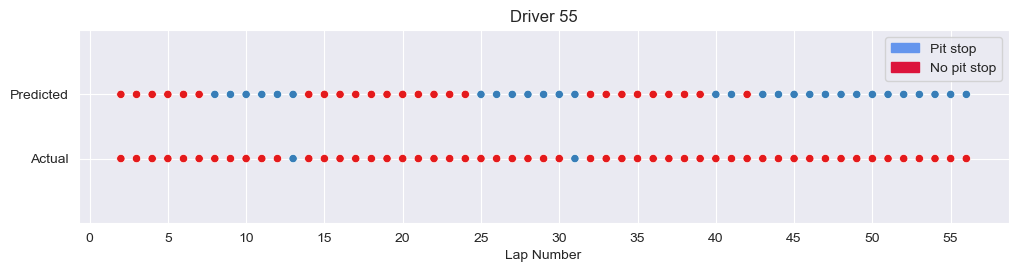

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (56, 64)


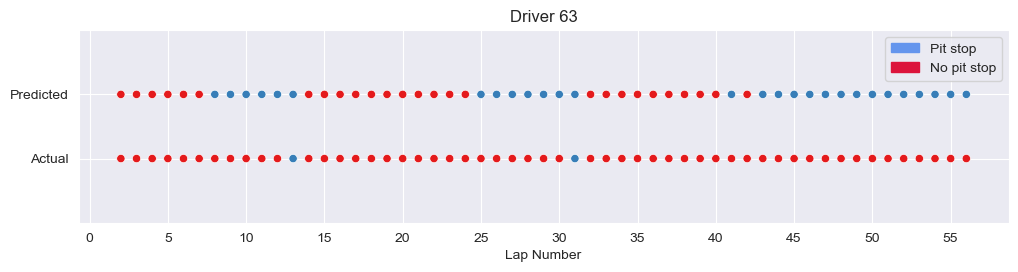

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 29)
Features added... (87845, 29)
Features removed... (87845, 29)
Features encoded... (56, 64)


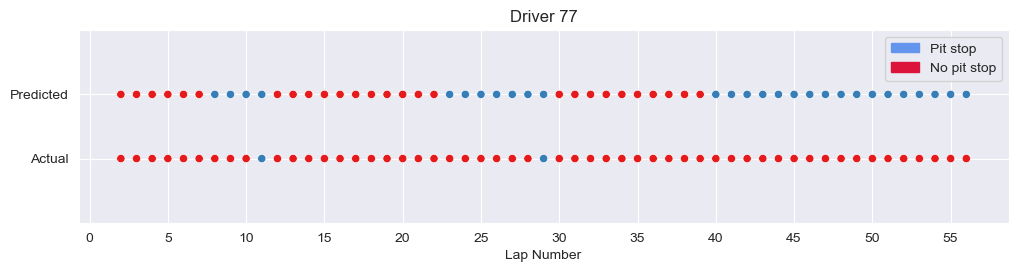

In [ ]:
test_data['Year'] = 2023
test_drivers = test_data.groupby('DriverNumber').agg({'LapNumber': 'max', 'TotalLaps': 'max'}).query('LapNumber == TotalLaps').index

for driver in test_drivers:
    test_df = test_data.query(f'DriverNumber == "{driver}"').copy()
    test_df = preprocess_new_data(test_df, data, encoder)
    test_df.dropna(inplace=True)
    x_test = test_df.drop('is_pitting', axis=1)
    y_test = test_df['is_pitting']
    ypred = model.predict(x_test)
    plot_predictions_by_lapNumber(x_test, y_test, ypred, title=f'Driver {driver}')